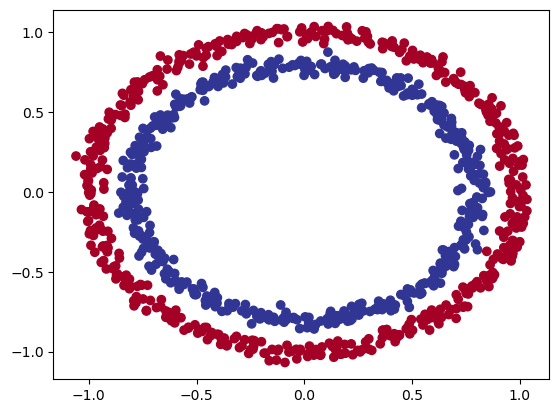

In [1]:
#Recreating non-linear data 
import matplotlib. pyplot as plt
from sklearn.datasets import make_circles



n_samples=1000
X,y = make_circles(n_samples,noise=0.03,
                   random_state=42)
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [2]:
#Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

#Split into train and test sets

X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.2,
                                               random_state=42)

X_train[:5],y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### Building a model with Non-linearity

-> non straight lines

In [3]:
from torch import nn 

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1=nn.Linear(in_features=2,out_features=20)
        self.layer_2=nn.Linear(in_features=20,out_features=20)
        self.layer_3=nn.Linear(in_features=20,out_features=1)
        self.relu=nn.ReLU() #nonlinear activation function

    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3=CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)

In [4]:
loss_fn=nn.BCEWithLogitsLoss()

optimizer=torch.optim.SGD(params=model_3.parameters(),lr=0.1)

def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc=(correct/len(y_pred))*100
    return acc


In [5]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000

X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epochs):

    model_3.train()

    y_logits=model_3(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))

    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #Testing

    model_3.eval()
    with torch.inference_mode():
        test_logits=model_3(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))

        test_loss=loss_fn(test_logits,y_test)
        test_acc=accuracy_fn(y_true=y_test,y_pred=test_pred)

    if epoch %100==0:
        print(f"Epoch: {epoch} | Loss:{loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f} , Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss:0.69281, Acc: 50.00% | Test loss: 0.69335 , Test acc: 50.00%
Epoch: 100 | Loss:0.68577, Acc: 55.38% | Test loss: 0.68817 , Test acc: 54.00%
Epoch: 200 | Loss:0.67953, Acc: 58.50% | Test loss: 0.68363 , Test acc: 55.00%
Epoch: 300 | Loss:0.67014, Acc: 58.13% | Test loss: 0.67623 , Test acc: 54.00%
Epoch: 400 | Loss:0.65410, Acc: 69.75% | Test loss: 0.66259 , Test acc: 66.50%
Epoch: 500 | Loss:0.62429, Acc: 85.62% | Test loss: 0.63589 , Test acc: 81.50%
Epoch: 600 | Loss:0.56826, Acc: 94.75% | Test loss: 0.58478 , Test acc: 91.00%
Epoch: 700 | Loss:0.46961, Acc: 98.88% | Test loss: 0.49392 , Test acc: 98.00%
Epoch: 800 | Loss:0.32757, Acc: 100.00% | Test loss: 0.36488 , Test acc: 99.50%
Epoch: 900 | Loss:0.19752, Acc: 100.00% | Test loss: 0.24223 , Test acc: 100.00%


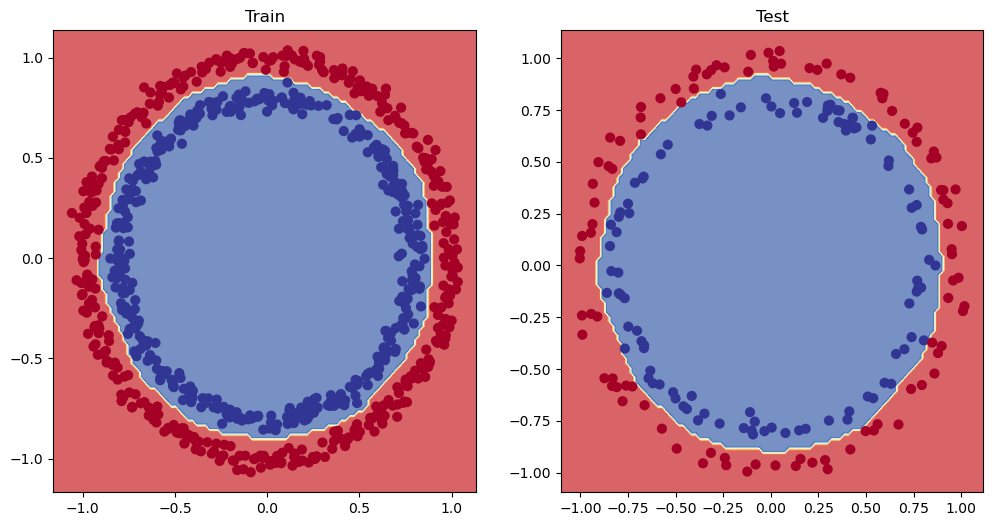

In [6]:
from helper_functions import plot_predictions,plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,y_test)

In [11]:
# Replicating non-linear activation functions
# Create a tensor

A = torch.arange(-10,10,1,dtype=torch.float32) #it must be float32

A.dtype,A

(torch.float32,
 tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]))

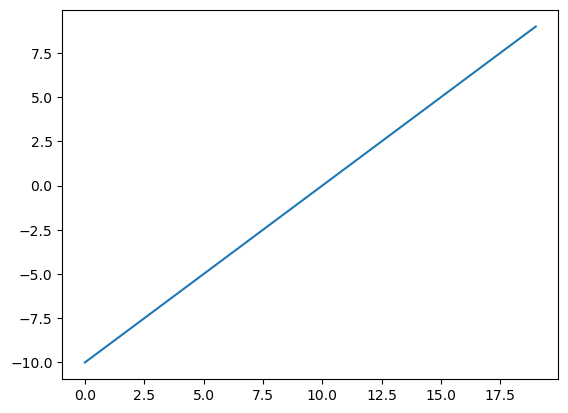

In [12]:
#Visualize the tensor
plt.plot(A)

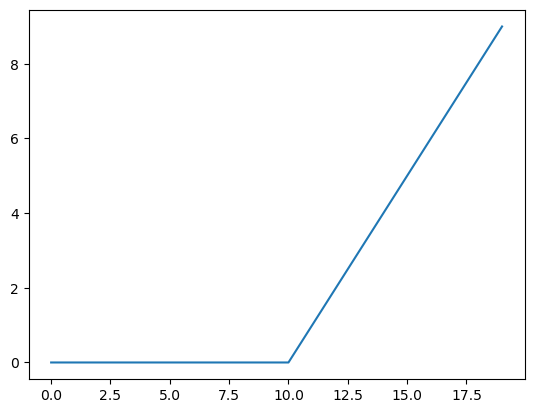

In [13]:
plt.plot(torch.relu(A))

In [14]:
def relu(x:torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0),x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

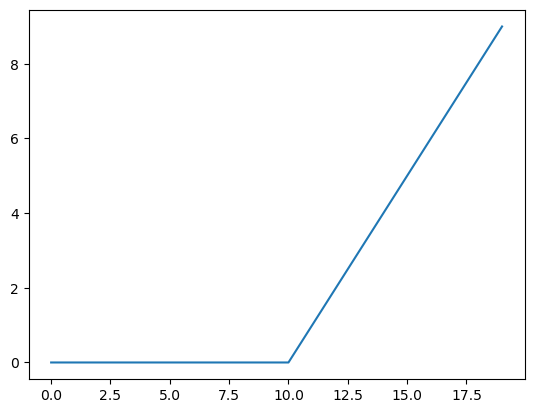

In [15]:
#PLot ReLU activation function

plt.plot(relu(A))

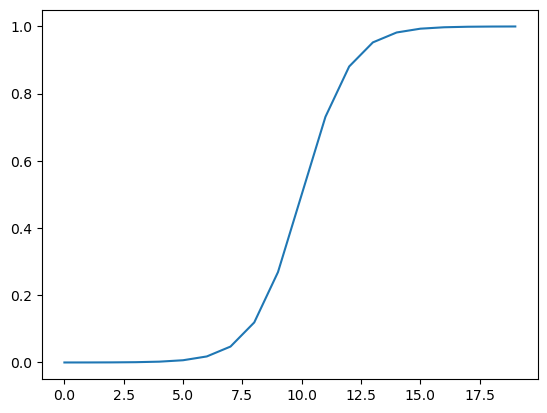

In [16]:
def sigmoid(x):
    return 1/(1 + torch.exp(-x))

plt.plot(torch.sigmoid(A))

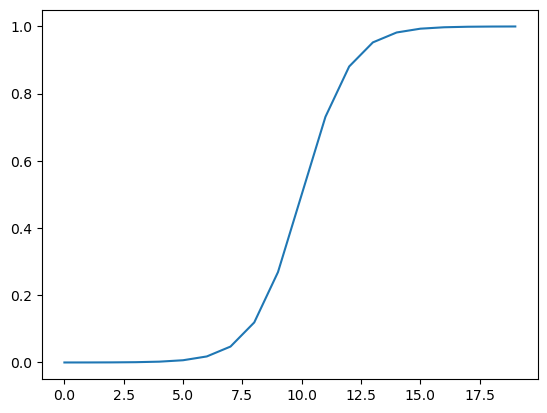

In [17]:
plt.plot(sigmoid(A))

### PUTTING IT ALL TOGETHER WITH A MULTI-CLASS CLASSIFICATION PROBLEM

* Binary classification = 1 or 0 

* Multi-class classification = more than one thing or another

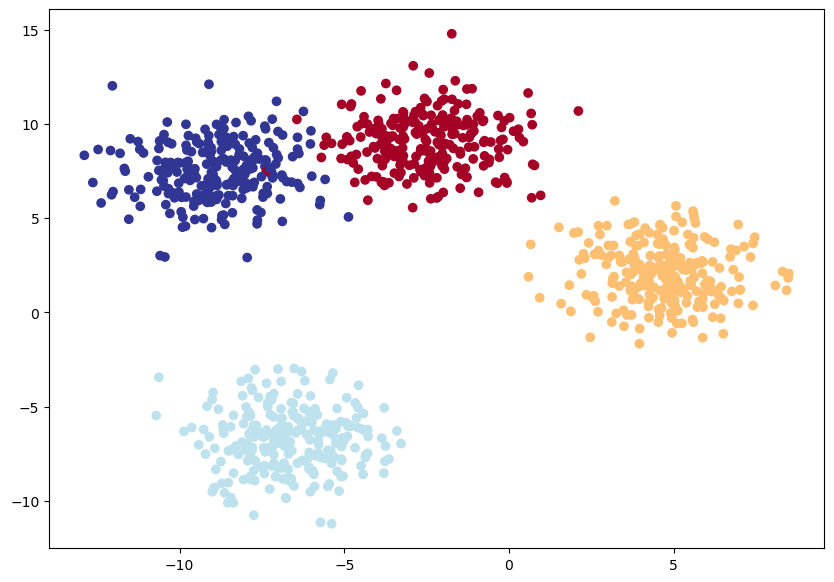

In [26]:
import torch
import matplotlib.pyplot as plt 
from sklearn.datasets import make_blobs 
from sklearn.model_selection import train_test_split

# Set hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED= 42

#1. Create multiclass data

X_blob,y_blob=make_blobs(n_samples=1000,
                         n_features=NUM_FEATURES,
                         centers=NUM_CLASSES,
                         cluster_std=1.5,
                         random_state=RANDOM_SEED)

#2. turn data into tensors

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.float)

#3. Split into train and test

X_blob_train,X_blob_test,y_blob_train,y_blob_test=train_test_split(X_blob,
                                                                   y_blob,
                                                                   test_size=0.2,
                                                                   random_state=RANDOM_SEED)

#4. Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)


### BUILDING A MULTI CLASS CLASIIFICATION MODEL IN PyTorch

In [28]:
class BLobModel(nn.Module):
    def __init__(self,input_features,output_features,hidden_units=8):
        """Initializes multi-class classification model.

        Args:
            input_features (int) : Number of input features to the model
            output_features(int): Number of output features (number of output classes)
            hidden_units(int): Number of hidden units between layers , default 8
        Returns:

        Example:
        """ 
        super().__init__()
        self.linear_layer_stack=nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)
        )
    def forward(self,x):
        return self.linear_layer_stack(x)
    
#Create an instance and send to target device

model_4=BLobModel(input_features=2,
                  output_features=4,
                  hidden_units=8).to(device)
model_4

BLobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [27]:
loss_fn=nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(params=model_4.parameters(),
                          lr=0.1)



(torch.Size([800, 2]), torch.Size([800]))

In [32]:
model_4.eval()

with torch.inference_mode():
    y_preds=model_4(X_blob_test.to(device))

y_preds[:10],y_blob_test

(tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
         [-0.0973, -0.9431, -0.5963, -0.1371],
         [ 0.2528, -0.2379,  0.1882, -0.0066],
         [-0.4134, -0.5204, -0.9303, -0.6963],
         [-0.3118, -1.3736, -1.1991, -0.3834],
         [-0.1497, -1.0617, -0.7107, -0.1645],
         [ 0.1539, -0.2887,  0.1520, -0.0109],
         [-0.2154, -1.1795, -0.9300, -0.2745],
         [ 0.2443, -0.2472,  0.1649,  0.0061],
         [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0'),
 tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0., 0., 1., 0., 0., 0., 3., 3., 2.,
         3., 3., 3., 0., 1., 2., 2., 2., 3., 0., 1., 0., 3., 1., 1., 3., 1., 2.,
         1., 3., 0., 2., 0., 3., 3., 2., 0., 3., 1., 1., 0., 3., 1., 0., 1., 1.,
         3., 2., 1., 1., 3., 2., 2., 0., 3., 2., 2., 0., 0., 3., 3., 0., 0., 3.,
         3., 3., 2., 3., 3., 3., 3., 1., 0., 2., 3., 2., 3., 3., 2., 3., 3., 2.,
         3., 3., 1., 3., 3., 3., 1., 0., 3., 2., 0., 0., 3., 0., 2., 3., 1., 0.,
         3., 2., 1., 1., 